In [21]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rcParams.update({'font.size': 18})

In [5]:
kB = 1.38e-23
m = 7 * 1.66e-27
C6 = 1394 # C6 for Li+Li
De = 334 # De for Li+Li
C12 = C6**2/(4*De) # C12 coefficient given atom-atom depth De

def VLJ(r):
    '''Lennard-Jones potential for a pair of atoms separated by distance r.'''
    return C12/r**12 - C6/r**6

def Vtot(r1,r2,r3):
    '''Total potential energy for all three atoms'''
    r12 = np.linalg.norm(r1-r2)
    r23 = np.linalg.norm(r2-r3)
    r13 = np.linalg.norm(r1-r3)
    return VLJ(r12) + VLJ(r23) + VLJ(r13)

def dVdr(rA,rB,rC):
    '''form of derivative of V for particle A interacting with B and C'''
    rAB = rA - rB
    rAC = rA - rC
    rABnorm = np.linalg.norm(rAB)
    rACnorm = np.linalg.norm(rAC)
    if (rABnorm>0 and rACnorm>0):
        deriv_x = (12*C12*rAB[0])/rABnorm**14 - (6*C6*rAB[0])/rABnorm**8 + \
                  (12*C12*rAC[0])/rACnorm**14 - (6*C6*rAC[0])/rACnorm**8
        deriv_y = (12*C12*rAB[1])/rABnorm**14 - (6*C6*rAB[1])/rABnorm**8 + \
                  (12*C12*rAC[1])/rACnorm**14 - (6*C6*rAC[1])/rACnorm**8
        deriv_z = (12*C12*rAB[2])/rABnorm**14 - (6*C6*rAB[2])/rABnorm**8 + \
                  (12*C12*rAC[2])/rACnorm**14 - (6*C6*rAC[2])/rACnorm**8
    else:
        deriv_x = 1000 * np.ones(3)
        deriv_y = 1000 * np.ones(3)
        deriv_z = 1000 * np.ones(3)
        
    return np.array([deriv_x, deriv_y, deriv_z])

In [30]:
# initial time
t0 = 0.0
# initial positions of each atom
rinit1 = 60.0
r0 = np.array([[-rinit1/3,0,0],
               [rinit1/6,-0.4,0],
               [rinit1/6,0.7,0]])
# initial velocities of each atom
T = 10
vinit = -np.sqrt(kB*T/m)/10 # in nm/ns
v0 = np.array([[-vinit,0,0],
               [0,0,0],
               [0,0,0]])
# group into vector  of ICs
s0 = np.array([r0,v0])
s0 = s0.flatten()
# rhs of ODE
def f(t, s):
    r1 = s[0:3]
    r2 = s[3:6]
    r3 = s[6:9]
    v1 = s[9:12]
    v2 = s[12:15]
    v3 = s[15:18]
    
    dV1 = dVdr(r1,r2,r3)
    dV2 = dVdr(r2,r1,r3)
    dV3 = dVdr(r3,r1,r2)
    
    output = np.array([v1,v2,v3,dV1,dV2,dV3]).flatten()
    return output

In [31]:
r = ode(f).set_integrator('dop853')
r.set_initial_value(s0, t0)
t1 = 100
dt = 0.01

x1out = np.zeros(int(np.ceil(t1/dt)))
y1out = np.zeros(int(np.ceil(t1/dt)))
z1out = np.zeros(int(np.ceil(t1/dt)))
x2out = np.zeros(int(np.ceil(t1/dt)))
y2out = np.zeros(int(np.ceil(t1/dt)))
z2out = np.zeros(int(np.ceil(t1/dt)))
x3out = np.zeros(int(np.ceil(t1/dt)))
y3out = np.zeros(int(np.ceil(t1/dt)))
z3out = np.zeros(int(np.ceil(t1/dt)))
n = 0
hyperrad = rinit1/2
while hyperrad < rinit1 and r.t < t1:
    ds = r.integrate(r.t+dt)
    x1out[n] = ds[0] + vinit* r.t /3
    y1out[n] = ds[1]
    z1out[n] = ds[2]
    x2out[n] = ds[3] + vinit* r.t /3
    y2out[n] = ds[4]
    z2out[n] = ds[5]
    x3out[n] = ds[6] + vinit* r.t /3
    y3out[n] = ds[7]
    z3out[n] = ds[8]
    hyperrad = np.sqrt(np.sum(ds[0:9]**2))
    n+=1

x1out = x1out[0:n]
y1out = y1out[0:n]
z1out = z1out[0:n]
x2out = x2out[0:n]
y2out = y2out[0:n]
z2out = z2out[0:n]
x3out = x3out[0:n]
y3out = y3out[0:n]
z3out = z3out[0:n]
print(r.t)

7.979999999999874


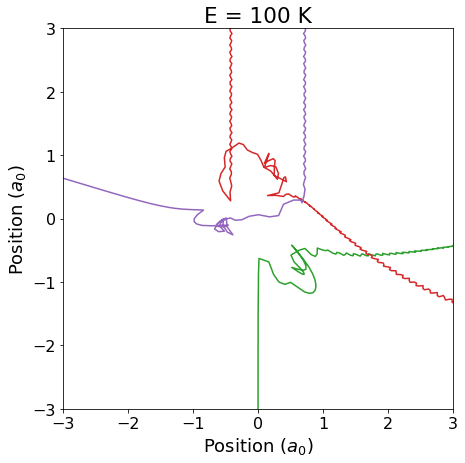

In [32]:
fig=plt.figure(figsize=(7,7))
plt.plot(y1out,x1out,'C2')
plt.plot(y2out,x2out,'C3')
plt.plot(y3out,x3out,'C4')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel("Position ($a_0$)")
plt.ylabel("Position ($a_0$)")
plt.title("E = 100 K")
fig.savefig("Col100K.pdf",bbox_inches='tight')

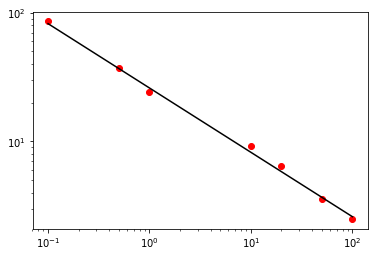

In [543]:
Tlist = [0.1, 0.5, 1, 10, 20,50, 100]
tlist = [85.52, 37.07, 24.32, 9.18, 6.4,3.54, 2.49]
Tpowerlaw = np.linspace(0.1,100,20)
plt.loglog(Tlist,tlist,'ro')
plt.loglog(Tpowerlaw,26/np.sqrt(Tpowerlaw),'k')